In [1]:
##数据预处理
import numpy as np
import pandas as pd
import time
import sqlite3


In [2]:
triplet_dataset=pd.read_csv('E:/jupyter/train_triplets.txt',sep='\t',header=None,names=['user','song','play_count'])
triplet_dataset.shape

(48373586, 3)

In [3]:
triplet_dataset.head()

,user,song,play_count
0,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAKIMP12A8C130995,1
1,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOAPDEY12A81C210A9,1
2,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBBMDR12A8C13253B,2
3,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFNSP12AF72A0E22,1
4,b80344d063b5ccb3212f76538f3d9e43d87dca9e,SOBFOVM12A58A7D494,1


**统计分析**

In [4]:
##用户播放量
output_dict={}
with open('E:/jupyter/train_triplets.txt') as f:
    for line_number,line in enumerate(f):
        ##找到当前的用户
        user=line.split('\t')[0]
        ##播放量
        play_count=int(line.split('\t')[2])
        ##如果字典中已经有该用户信息，在其基础上增加当前的播放量
        if user in output_dict:
            play_count +=output_dict[user]
            output_dict.update({user:play_count})
        output_dict.update({user:play_count})
    output_list=[{'user':k,'play_count':v} for k,v in output_dict.items()]
    ##转换成DF格式
    play_count_df=pd.DataFrame(output_list)
    ##排序
    play_count_df=play_count_df.sort_values(by='play_count',ascending=False)
    play_count_df.to_csv('E:/jupyter/user_playcount_df.csv',index=False)

In [7]:
##歌曲播放量
output_dict={}##方便关键字读取
with open('E:/jupyter/train_triplets.txt') as f:
    for line_number,line in enumerate(f):
        ##当前歌曲
        song=line.split('\t')[1]
        ##播放次数
        play_count=int(line.split('\t')[2])
        if song in output_dict:
            play_count +=output_dict[song]
            output_dict.update({song:play_count})
        output_dict.update({song:play_count})
output_list=[{'song':k,'play_count':v} for k,v in output_dict.items()]
song_count_df=pd.DataFrame(output_list)
song_count_df=song_count_df.sort_values(by='play_count',ascending=False)
##保存
song_count_df.to_csv('E:/jupyter/song_playcount_df.csv',index=False)


In [8]:
play_count_df=pd.read_csv('E:/jupyter/user_playcount_df.csv')
play_count_df.head()

,play_count,user
0,13132,093cb74eb3c517c5179ae24caf0ebec51b24d2a2
1,9884,119b7c88d58d0c6eb051365c103da5caf817bea6
2,8210,3fa44653315697f42410a30cb766a4eb102080bb
3,7015,a2679496cd0af9779a92a13ff7c6af5c81ea8c7b
4,6494,d7d2d888ae04d16e994d6964214a1de81392ee04


In [9]:
song_count_df=pd.read_csv('E:/jupyter/song_playcount_df.csv')
song_count_df.head()

,play_count,song
0,726885,SOBONKR12A58A7A7E0
1,648239,SOAUWYT12A81C206F1
2,527893,SOSXLTC12AF72A7F54
3,425463,SOFRQTD12A81C233C0
4,389880,SOEGIYH12A6D4FC0E3


In [10]:
##前10万名用户的播放量占总体的比例
total_play_count=sum(song_count_df.play_count)
print((float(play_count_df.head(100000).play_count.sum())/total_play_count)*100)

40.8807280500655


In [11]:
###前3万首歌的播放量
total_play_count=sum(song_count_df.play_count)
print((float(song_count_df.head(30000).play_count.sum())/total_play_count)*100)

78.39315366645269


**清洗数据**

In [16]:
##拿到这些用户和歌曲
play_count_subset=play_count_df.head(100000)
song_count_subset=song_count_df.head(30000)
user_subset=list(play_count_subset.user)
song_subset=list(song_count_subset.song)


##读取原数据集
triplet_dataset=pd.read_csv('E:/jupyter/train_triplets.txt',sep='\t',header=None,names=['user','song','play_count'])
##只保留10万名用户的数据
triplet_dataset_sub=triplet_dataset[triplet_dataset.user.isin(user_subset)]
#del(triplet_dataset)

##保留有这3万首歌的数据
triplet_dataset_sub_song=triplet_dataset_sub[triplet_dataset_sub.song.isin(song_subset)]
#del(triplet_dataset_sub)
##保存数据
triplet_dataset_sub_song.to_csv('E:/jupyter/triplet_dataset_sub_song.csv',index=False)

In [17]:
triplet_dataset_sub_song.shape

(10774558, 3)

In [18]:
triplet_dataset_sub_song.head()

,user,song,play_count
498,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12
499,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1
500,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1
501,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1
502,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7


**数据集整合**

In [19]:
##更多歌曲的信息
conn=sqlite3.connect('E:/jupyter/track_metadata.db')
cur=conn.cursor()
cur.execute("SELECT name FROM sqlite_master WHERE type='table'")
cur.fetchall

track_metadata_df=pd.read_sql(con=conn,sql='select * from songs')
track_metadata_df_sub=track_metadata_df[track_metadata_df.song_id.isin(song_subset)]
##保存为csv文件
track_metadata_df_sub.to_csv('E:/jupyter/track_metadata_df_sub.csv',index=False)

In [21]:
track_metadata_df_sub=pd.read_csv('E:/jupyter/track_metadata_df_sub.csv',encoding='ISO-8859-1')
track_metadata_df_sub.head()

,track_id,title,song_id,release,artist_id,artist_mbid,artist_name,duration,artist_familiarity,artist_hotttnesss,year,track_7digitalid,shs_perf,shs_work
0,TRMMGCB128E079651D,Get Along (Feat: Pace Won) (Instrumental),SOHNWIM12A67ADF7D9,Charango,ARU3C671187FB3F71B,067102ea-9519-4622-9077-57ca4164cfbb,Morcheeba,227.47383,0.819087,0.533117,2002,185967,-1,0
1,TRMMGTX128F92FB4D9,Viejo,SOECFIW12A8C144546,Caraluna,ARPAAPH1187FB3601B,f69d655c-ffd6-4bee-8c2a-3086b2be2fc6,Bacilos,307.51302,0.595554,0.400705,0,6825058,-1,0
2,TRMMGDP128F933E59A,I Say A Little Prayer,SOGWEOB12AB018A4D0,The Legendary Hi Records Albums_ Volume 3: Ful...,ARNNRN31187B9AE7B7,fb7272ba-f130-4f0a-934d-6eeea4c18c9a,Al Green,133.58975,0.779490,0.599210,1978,5211723,-1,11898
3,TRMMHBF12903CF6E59,At the Ball_ That's All,SOJGCRL12A8C144187,Best of Laurel & Hardy - The Lonesome Pine,AR1FEUF1187B9AF3E3,4a8ae4fd-ad6f-4912-851f-093f12ee3572,Laurel & Hardy,123.71546,0.438709,0.307120,0,8645877,-1,0
4,TRMMHKG12903CDB1B5,Black Gold,SOHNFBA12AB018CD1D,Total Life Forever,ARVXV1J1187FB5BF88,6a65d878-fcd0-42cf-aff9-ca1d636a8bcc,Foals,386.32444,0.842578,0.514523,2010,9007438,-1,0


**提取特征，去掉无用的信息**

In [22]:
del(track_metadata_df_sub['track_id'])
del(track_metadata_df_sub['artist_mbid'])

##去重
track_metadata_df_sub=track_metadata_df_sub.drop_duplicates(['song_id'])
##整合在一起
triplet_dataset_sub_song_merged=pd.merge(triplet_dataset_sub_song,track_metadata_df_sub,how='left',left_on='song',right_on='song_id')
##更改列名
triplet_dataset_sub_song_merged.rename(columns={'play_count':'listen_count'},inplace=True)

##去掉不需要的指标
del(triplet_dataset_sub_song_merged['song_id'])
del(triplet_dataset_sub_song_merged['artist_id'])
del(triplet_dataset_sub_song_merged['duration'])
del(triplet_dataset_sub_song_merged['artist_familiarity'])
del(triplet_dataset_sub_song_merged['artist_hotttnesss'])
del(triplet_dataset_sub_song_merged['track_7digitalid'])
del(triplet_dataset_sub_song_merged['shs_perf'])
del(triplet_dataset_sub_song_merged['shs_work'])

In [23]:
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0


**冷启动:给新用户推荐排行榜单**

In [24]:
import matplotlib.pyplot as plt
plt.rcdefaults()
import numpy as np


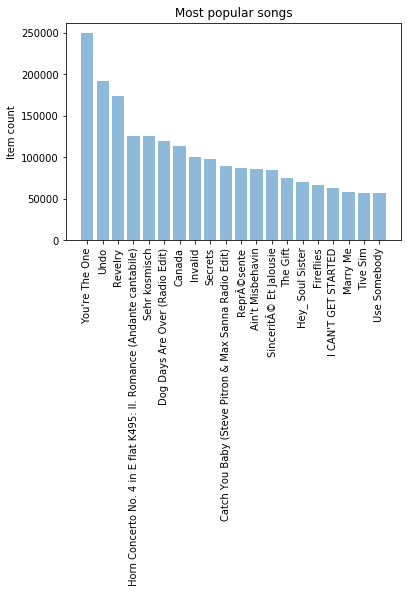

In [26]:
#按歌曲名字来统计其播放量的总数
popular_songs=triplet_dataset_sub_song_merged[['title','listen_count']].groupby('title').sum().reset_index()
#对结果排序
popular_songs_top_20=popular_songs.sort_values('listen_count',ascending=False).head(20)
##转换成list格式方便画图
objects=(list(popular_songs_top_20['title']))
##设置位置
y_pos=np.arange(len(objects))
##对应结果
performance=list(popular_songs_top_20['listen_count'])
##绘图
plt.bar(y_pos,performance,align='center',alpha=0.5)
plt.xticks(y_pos,objects,rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular songs')
plt.show()


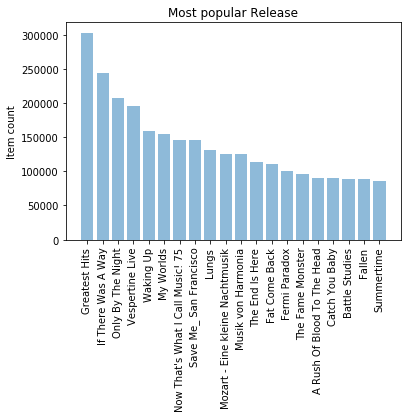

In [27]:
##按专辑名字统计播放量
popular_release=triplet_dataset_sub_song_merged[['release','listen_count']].groupby('release').sum().reset_index()
#对结果排序
popular_release_top_20=popular_release.sort_values('listen_count',ascending=False).head(20)
##转换成list格式方便画图
objects=(list(popular_release_top_20['release']))
##设置位置
y_pos=np.arange(len(objects))
##对应结果
performance=list(popular_release_top_20['listen_count'])
##绘图
plt.bar(y_pos,performance,align='center',alpha=0.5)
plt.xticks(y_pos,objects,rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Release')
plt.show()

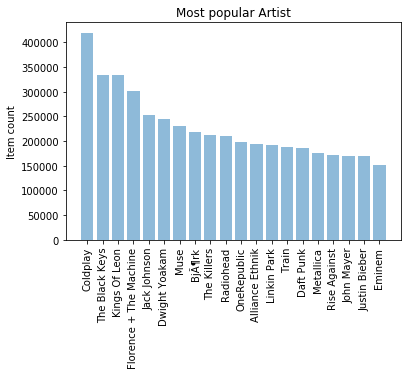

In [29]:
##按歌手来统计播放量
popular_artist=triplet_dataset_sub_song_merged[['artist_name','listen_count']].groupby('artist_name').sum().reset_index()
#对结果排序
popular_artist_top_20=popular_artist.sort_values('listen_count',ascending=False).head(20)
##转换成list格式方便画图
objects=(list(popular_artist_top_20['artist_name']))
##设置位置
y_pos=np.arange(len(objects))
##对应结果
performance=list(popular_artist_top_20['listen_count'])
##绘图
plt.bar(y_pos,performance,align='center',alpha=0.5)
plt.xticks(y_pos,objects,rotation='vertical')
plt.ylabel('Item count')
plt.title('Most popular Artist')
plt.show()

In [32]:
##用户分布情况
user_song_count_distribution=triplet_dataset_sub_song_merged[['user','title']].groupby('user').count().reset_index().sort_values(by='title',ascending=False)
user_song_count_distribution.title.describe()

count    99996.000000
mean       107.749890
std         79.742561
min          1.000000
25%         53.000000
50%         89.000000
75%        141.000000
max       1189.000000
Name: title, dtype: float64

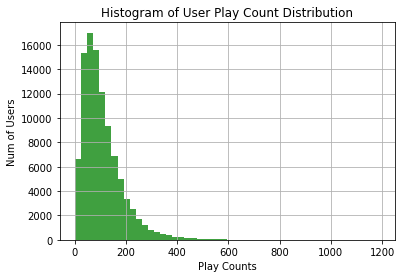

In [38]:
x=user_song_count_distribution.title
n,bins,patches=plt.hist(x,50,facecolor='green',alpha=0.75)
plt.xlabel('Play Counts')
plt.ylabel('Num of Users')
plt.title(r'Histogram of User Play Count Distribution')
plt.grid(True)
plt.show()

In [39]:
user_song_count_distribution.head()

,user,title
54751,8cb51abc6bf8ea29341cb070fe1e1af5e4c3ffcc,1189
30566,4e73d9e058d2b1f2dba9c1fe4a8f416f9f58364f,1185
75364,c1255748c06ee3f6440c51c439446886c7807095,1149
6737,119b7c88d58d0c6eb051365c103da5caf817bea6,1120
58860,96f7b4f800cafef33eae71a6bc44f7139f63cd7a,1078


In [40]:
triplet_dataset_sub_song_merged[['user','title']].head()

,user,title
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,You And Me Jesus
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,Harder Better Faster Stronger
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,Uprising
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,Breakfast At Tiffany's
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,Lucky (Album Version)


**基于相似度推荐**


In [54]:
##排行榜推荐
def create_popularity_recommendation(train_data,user_id,item_id):
    ##由指定的特征来统计其播报情况，可以选择歌曲名，专辑名，歌手名
    train_data_grouped=train_data.groupby([item_id]).agg({user_id:'count'}).reset_index()
    train_data_grouped.rename(columns={user_id:'score'},inplace=True)
    train_data_sort=train_data_grouped.sort_values(['score',item_id],ascending=[0,1])
    ##加入排行等级
    train_data_sort['Rank']=train_data_sort['score'].rank(ascending=0,method='first')
    ##返回个数的推荐结果
    popularity_recommendations=train_data_sort.head(20)
    return popularity_recommendations
recommendations=create_popularity_recommendation(triplet_dataset_sub_song_merged,'user','title')

In [55]:
##歌曲相似度推荐
song_count_subset=song_count_subset.head(5000)
user_subset=list(play_count_subset)
song_subset=list(song_count_subset)
triplet_dataset_sub_song_merged_sub=triplet_dataset_sub_song_merged[triplet_dataset_sub_song_merged.song.isin(song_subset)]

In [56]:
# Thanks to Siraj Raval for this module


import numpy as np
import pandas

#Class for Popularity based Recommender System model
class popularity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.popularity_recommendations = None
        
    #Create the popularity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

        #Get a count of user_ids for each unique song as recommendation score
        train_data_grouped = train_data.groupby([self.item_id]).agg({self.user_id: 'count'}).reset_index()
        train_data_grouped.rename(columns = {user_id: 'score'},inplace=True)
    
        #Sort the songs based upon recommendation score
        train_data_sort = train_data_grouped.sort_values(['score', self.item_id], ascending = [0,1])
    
        #Generate a recommendation rank based upon score
        train_data_sort['Rank'] = train_data_sort['score'].rank(ascending=0, method='first')
        
        #Get the top 10 recommendations
        self.popularity_recommendations = train_data_sort.head(10)

    #Use the popularity based recommender system model to
    #make recommendations
    def recommend(self, user_id):    
        user_recommendations = self.popularity_recommendations
        
        #Add user_id column for which the recommendations are being generated
        user_recommendations['user_id'] = user_id
    
        #Bring user_id column to the front
        cols = user_recommendations.columns.tolist()
        cols = cols[-1:] + cols[:-1]
        user_recommendations = user_recommendations[cols]
        
        return user_recommendations
    

#Class for Item similarity based Recommender System model
class item_similarity_recommender_py():
    def __init__(self):
        self.train_data = None
        self.user_id = None
        self.item_id = None
        self.cooccurence_matrix = None
        self.songs_dict = None
        self.rev_songs_dict = None
        self.item_similarity_recommendations = None
        
    #Get unique items (songs) corresponding to a given user
    def get_user_items(self, user):
        user_data = self.train_data[self.train_data[self.user_id] == user]
        user_items = list(user_data[self.item_id].unique())
        
        return user_items
        
    #Get unique users for a given item (song)
    def get_item_users(self, item):
        item_data = self.train_data[self.train_data[self.item_id] == item]
        item_users = set(item_data[self.user_id].unique())
            
        return item_users
        
    #Get unique items (songs) in the training data
    def get_all_items_train_data(self):
        all_items = list(self.train_data[self.item_id].unique())
            
        return all_items
        
    #Construct cooccurence matrix
    def construct_cooccurence_matrix(self, user_songs, all_songs):
            
        ####################################
        #Get users for all songs in user_songs.
        ####################################
        user_songs_users = []        
        for i in range(0, len(user_songs)):
            user_songs_users.append(self.get_item_users(user_songs[i]))
            
        ###############################################
        #Initialize the item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = np.matrix(np.zeros(shape=(len(user_songs), len(all_songs))), float)
           
        #############################################################
        #Calculate similarity between user songs and all unique songs
        #in the training data
        #############################################################
        for i in range(0,len(all_songs)):
            #Calculate unique listeners (users) of song (item) i
            songs_i_data = self.train_data[self.train_data[self.item_id] == all_songs[i]]
            users_i = set(songs_i_data[self.user_id].unique())
            
            for j in range(0,len(user_songs)):       
                    
                #Get unique listeners (users) of song (item) j
                users_j = user_songs_users[j]
                    
                #Calculate intersection of listeners of songs i and j
                users_intersection = users_i.intersection(users_j)
                
                #Calculate cooccurence_matrix[i,j] as Jaccard Index
                if len(users_intersection) != 0:
                    #Calculate union of listeners of songs i and j
                    users_union = users_i.union(users_j)
                    
                    cooccurence_matrix[j,i] = float(len(users_intersection))/float(len(users_union))
                else:
                    cooccurence_matrix[j,i] = 0
                    
        
        return cooccurence_matrix

    
    #Use the cooccurence matrix to make top recommendations
    def generate_top_recommendations(self, user, cooccurence_matrix, all_songs, user_songs):
        print("Non zero values in cooccurence_matrix :%d" % np.count_nonzero(cooccurence_matrix))
        
        #Calculate a weighted average of the scores in cooccurence matrix for all user songs.
        user_sim_scores = cooccurence_matrix.sum(axis=0)/float(cooccurence_matrix.shape[0])
        user_sim_scores = np.array(user_sim_scores)[0].tolist()
 
        #Sort the indices of user_sim_scores based upon their value
        #Also maintain the corresponding score
        sort_index = sorted(((e,i) for i,e in enumerate(list(user_sim_scores))), reverse=True)
    
        #Create a dataframe from the following
        columns = ['user_id', 'song', 'score', 'rank']
        #index = np.arange(1) # array of numbers for the number of samples
        df = pandas.DataFrame(columns=columns)
         
        #Fill the dataframe with top 10 item based recommendations
        rank = 1 
        for i in range(0,len(sort_index)):
            if ~np.isnan(sort_index[i][0]) and all_songs[sort_index[i][1]] not in user_songs and rank <= 10:
                df.loc[len(df)]=[user,all_songs[sort_index[i][1]],sort_index[i][0],rank]
                rank = rank+1
        
        #Handle the case where there are no recommendations
        if df.shape[0] == 0:
            print("The current user has no songs for training the item similarity based recommendation model.")
            return -1
        else:
            return df
 
    #Create the item similarity based recommender system model
    def create(self, train_data, user_id, item_id):
        self.train_data = train_data
        self.user_id = user_id
        self.item_id = item_id

    #Use the item similarity based recommender system model to
    #make recommendations
    def recommend(self, user):
        
        ########################################
        #A. Get all unique songs for this user
        ########################################
        user_songs = self.get_user_items(user)    
            
        print("No. of unique songs for the user: %d" % len(user_songs))
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
                
        return df_recommendations
    
    #Get similar items to given items
    def get_similar_items(self, item_list):
        
        user_songs = item_list
        
        ######################################################
        #B. Get all unique items (songs) in the training data
        ######################################################
        all_songs = self.get_all_items_train_data()
        
        print("no. of unique songs in the training set: %d" % len(all_songs))
         
        ###############################################
        #C. Construct item cooccurence matrix of size 
        #len(user_songs) X len(songs)
        ###############################################
        cooccurence_matrix = self.construct_cooccurence_matrix(user_songs, all_songs)
        
        #######################################################
        #D. Use the cooccurence matrix to make recommendations
        #######################################################
        user = ""
        df_recommendations = self.generate_top_recommendations(user, cooccurence_matrix, all_songs, user_songs)
         
        return df_recommendations

**奇异值分解推荐SVD**

In [58]:
triplet_dataset_sub_song_merged_sum_df=triplet_dataset_sub_song_merged[['user','listen_count']].groupby('user').sum().reset_index()
triplet_dataset_sub_song_merged_sum_df.rename(columns={'listen_count':'total_listen_count'},inplace=True)
triplet_dataset_sub_song_merged=pd.merge(triplet_dataset_sub_song_merged,triplet_dataset_sub_song_merged_sum_df)
triplet_dataset_sub_song_merged.head()

,user,song,listen_count,title,release,artist_name,year,total_listen_count
0,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOADQPP12A67020C82,12,You And Me Jesus,Tribute To Jake Hess,Jake Hess,2004,329
1,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAFTRR12AF72A8D4D,1,Harder Better Faster Stronger,Discovery,Daft Punk,2007,329
2,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOANQFY12AB0183239,1,Uprising,Uprising,Muse,0,329
3,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOAYATB12A6701FD50,1,Breakfast At Tiffany's,Home,Deep Blue Something,1993,329
4,d6589314c0a9bcbca4fee0c93b14bc402363afea,SOBOAFP12A8C131F36,7,Lucky (Album Version),We Sing. We Dance. We Steal Things.,Jason Mraz & Colbie Caillat,0,329
